# Images Analysis
We are given 4 types of images, and each of the image belongs to one of the following 4 classes:

* Animals
* Birds
* Fish
* Reptiles

For this project we need the following packages and python3 for this project:

* numpy
* pandas
* keras
* opencv2
* os
* sklearn

In [105]:
import numpy as np
import pandas as pd
import cv2
import keras
import os
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer

## Data preparation

The images are given in 4 folders, and these 4 folders were decompressed and saved to the current folder. We will be reading these 4 folders and preparing a data frame consisting of the target label _y_ and the Image (numpy matrix)  

In [15]:
image_files = os.listdir("./Images Compressed")

The "Images Compressed" has the following directories. We will use the first part of the directory as the target class name. For example, the "Animals Compressed" directory has all the animal images, and we will use "Animals" as the target label while reading the images of "Animal Compressed" directory.

In [16]:
#The 
image_files

['Animals Compressed',
 'Birds Compressed',
 'Fish Compressed',
 'Reptiles compressed']

Before going too far, let us check how many images are present in each class. My goal is to use a CNN (Convolutional Neural Network) and neural networks need good amount of data to achieve a better accuracy.

In [23]:
classes = []
for directory in image_files:
    files = os.listdir("./Images Compressed/"+directory)
    classes.append((directory.split()[0],len(files)))

### Classes distribution

In [25]:
counts_df = pd.DataFrame(classes,columns=('class','count'))
counts_df.index = counts_df['class']
counts_df.drop(['class'],axis=1,inplace=True)
counts_df

,count
class,
Animals,18
Birds,17
Fish,16
Reptiles,6


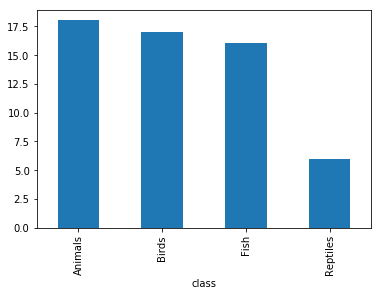

In [28]:
counts_df['count'].plot("bar",)

The number of images in each class is very low. We need to artificially create more images, so that our neural network gets good accuracy. Also the reptiles class is under represented, when compared to other classes. But right now we will ignore this fact, and apply the same transformations to all images.

1. Shift image by 1 pixel to left
2. Shift image by 2 pixels to left
3. Shift image by 1 pixel to right
4. Shift image by 2 pixel to right
5. Shift image by 1 pixel to up
6. Shift image by 2 pixels to up
7. Shift image by 1 pixel to down
8. Shift image by 2 pixel to down

Perform various combinations. For one image, we should get 24 additional images.

These transformations will give us more instances to train neural network. 

### Quick check of image size

What is the image size? If the image size is very big it becomes difficult for us to process it. So we will transform the image to 128 X 128 pixels irrespective of its size. Let us display an image and check its size for intution.

Image shape: (3456, 5184, 3)


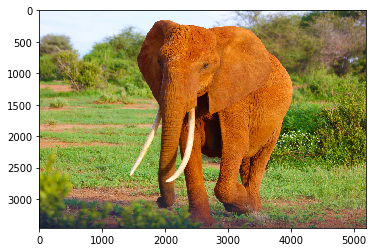

In [68]:
image_name = os.listdir("./Images Compressed/Animals Compressed/")[0]
sample_image = cv2.imread("./Images Compressed/Animals Compressed/"+image_name)
#CV2 reads image in BGR fashion, while matplotlib expects image in RGB fashion.
#So split the image, then reorder the B, G, R Channels to R, G, B, and then display
B, G, R = cv2.split(sample_image)
sample_image = cv2.merge([R, G, B])

plt.imshow(sample_image)

print("Image shape: {}".format(sample_image.shape))

The sample image is really big. So we need to resize it to a manageable size of 128X128X3 size.

We will put all the transformed images for training at "./Images Compressed/training"

In [72]:
#create a training directory if does not exist
directroy = ".\Images Compressed\training"

if not os.path.exists(directory):
    os.makedirs(directory)

### Transformation

The following helper function will perform all the above mentioned transformations:


In [43]:
#Helper function to perform transform
def transform(image, x=0, y=0):
    '''
    if x > 0 then shift image right by x pixels.
    if x < 0 then shift image left by x pixels.
    if y > 0 then shift image down by y pixels.
    if y < 0 then shift image up by y pixels.
    '''
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

### Data preparation
Prepare data for training

In [157]:

def prepare_training_data(images_dir="./Images Compressed"):
    '''
    '''
    labels = []
    features = []
    
    x_list = list(range(-2,3))
    y_list = list(range(-2,3))
    x_y_combinations = list(product(x_list, y_list))
        
    directories = os.listdir(images_dir)
    for directory in directories:
        label = directory.split()[0]
        image_names = os.listdir("./Images Compressed/"+directory)
 
        for image_name in image_names:
            #print("./Images Compressed/"+images_dir+"/"+image_name)
            #Read the image
            image = cv2.imread(images_dir+"/"+directory+"/"+image_name)
            for x, y in x_y_combinations:
                shifted = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
                shifted = transform(shifted, x, y)
                features.append(shifted)
                labels.append(label)
    return features, labels

### Call the data preparation function
Let us generate the training data

In [158]:
X, y = prepare_training_data(images_dir="./Images Compressed")

### Display a sampled resized image

Size of image =(128, 128, 3)


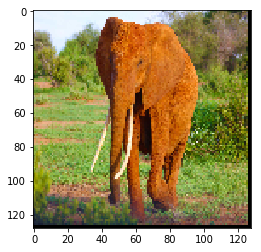

In [159]:
image = X[0]
B,G,R = cv2.split(image)
image = cv2.merge([R, G, B])
plt.imshow(image)
print("Size of image ={}".format(image.shape))

Normalize the X data (since we get good performance if the inputs are in the range of [0,1]. Since the pixels have a maximum value of 255, we will divide all pixels by 255

In [160]:
X = np.array(X)/255

### Split the data into test and train
Let us split the data int test (20%) and training(80%) stratified by class.

In [161]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

### Check distribution of classes in training

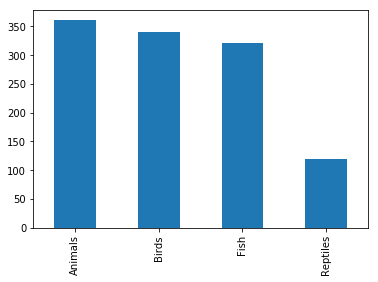

In [162]:
pd.Series(y_train).value_counts().plot("bar")

### Check distribution of classes in test data

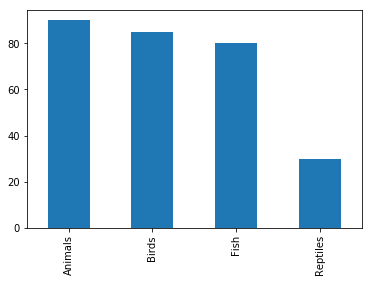

In [163]:
pd.Series(y_test).value_counts().plot("bar")

The above plots confirm that we obtained identical distribution of classes in both test and training data

### One hot encoding
One hot encoding is needed before we apply CNN model

In [164]:
#Create a binarizer class
label_binarizer = LabelBinarizer()
label_binarizer.fit(y)
y_train_encoded = label_binarizer.transform(y_train)
y_test_encoded = label_binarizer.transform(y_test)

Display some sample encoded records

In [165]:
for i in range(10):
    print(list(zip(y_train, y_train_encoded))[i])

('Birds', array([0, 1, 0, 0]))
('Birds', array([0, 1, 0, 0]))
('Reptiles', array([0, 0, 0, 1]))
('Reptiles', array([0, 0, 0, 1]))
('Animals', array([1, 0, 0, 0]))
('Fish', array([0, 0, 1, 0]))
('Animals', array([1, 0, 0, 0]))
('Fish', array([0, 0, 1, 0]))
('Fish', array([0, 0, 1, 0]))
('Birds', array([0, 1, 0, 0]))


### Training
Let us train the model now.

In [166]:
input_shape = X[0].shape
model = Sequential()

model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

#model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(4, activation='softmax'))

#compile the model:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
__________

In [167]:
#Train the model:
#checkpointer = ModelCheckpoint(filepath='pwc.model.best', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train_encoded, batch_size=64, epochs=8, validation_split=0.2, 
                verbose=1, shuffle=True)

Train on 912 samples, validate on 228 samples
Epoch 1/8
912/912 [==============================] - 18s 20ms/step - loss: 1.8401 - acc: 0.5186 - val_loss: 0.3440 - val_acc: 0.9167
Epoch 2/8
912/912 [==============================] - 17s 19ms/step - loss: 0.4507 - acc: 0.8662 - val_loss: 0.4964 - val_acc: 0.7763
Epoch 3/8
912/912 [==============================] - 17s 19ms/step - loss: 0.1749 - acc: 0.9529 - val_loss: 0.0275 - val_acc: 1.0000
Epoch 4/8
912/912 [==============================] - 17s 19ms/step - loss: 0.2432 - acc: 0.9496 - val_loss: 0.0494 - val_acc: 1.0000
Epoch 5/8
912/912 [==============================] - 17s 19ms/step - loss: 0.0200 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 6/8
912/912 [==============================] - 17s 19ms/step - loss: 0.1173 - acc: 0.9616 - val_loss: 0.0837 - val_acc: 0.9912
Epoch 7/8
912/912 [==============================] - 17s 19ms/step - loss: 0.0346 - acc: 0.9912 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 8/8
912/912 [====

### Getting the test accuracy

In [168]:
y_prob = model.predict(X_test)

#y_prob = model.predict(x) 
pred_test_labels = y_prob.argmax(axis=-1)
actual_test_labels = y_test_encoded.argmax(axis=-1)

from sklearn.metrics import classification_report
print(classification_report(actual_test_labels, pred_test_labels))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        90
          1       1.00      1.00      1.00        85
          2       1.00      1.00      1.00        80
          3       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00       285



**We can observe that we are getting an accuracy of almost 100% for our test data. The result looks too good to be true. Perhaps overfitting might be happening. Given that we have very less number of images, and we have generated artificial images by transformations, we cannot deny a chance of averfit. If we have more time or data, we can analyze if over fitting is really happening**



Displaying some test images (randomly)

In [173]:
#helper function to display image
def display_image(image, true_label):
    B,G,R = cv2.split(image)
    dis_image = cv2.merge([R, G, B])
    plt.imshow(dis_image)

    #Get probability
    pred_prob = model.predict(np.reshape(image,(1,128,128,3)))
    print("Animals probability: {}%".format(pred_prob[0][0]*100))
    print("Birds probability: {}%".format(pred_prob[0][1]*100))
    print("Fishes probability: {}%".format(pred_prob[0][2]*100))
    print("Reptiles probability: {}%".format(pred_prob[0][3]*100))
    #print(pred_prob)
    label = np.array(['Animals','Birds','Fish','Reptile'])
    print("Pridicted label: {}".format(label[pred_prob.argmax(axis=-1)][0]))
    print("True label: {}".format(true_label))

Animals probability: 99.99959468841553%
Birds probability: 0.0004099215857422678%
Fishes probability: 9.130889403949349e-11%
Reptiles probability: 1.2732478182897466e-06%
Pridicted label: Animals
True label: Animals


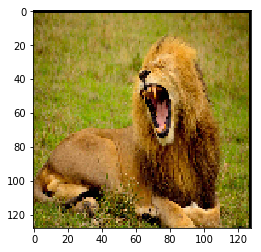

In [204]:
image = X_test[100]
true_label=y_test[100]
display_image(image, true_label)

Animals probability: 0.01741560990922153%
Birds probability: 99.96139407157898%
Fishes probability: 3.375263801785877e-06%
Reptiles probability: 0.021196302259340882%
Pridicted label: Birds
True label: Birds


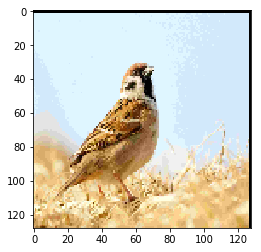

In [205]:
image = X_test[2]
true_label=y_test[2]
display_image(image, true_label)

Animals probability: 0.00010665916079233284%
Birds probability: 0.0007392367024294799%
Fishes probability: 99.99914169311523%
Reptiles probability: 7.457020956280758e-06%
Pridicted label: Fish
True label: Fish


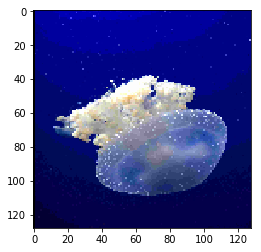

In [207]:
image = X_test[13]
true_label=y_test[13]
display_image(image, true_label)

Animals probability: 0.4891646560281515%
Birds probability: 99.37969446182251%
Fishes probability: 0.05200656596571207%
Reptiles probability: 0.07913984591141343%
Pridicted label: Birds
True label: Birds


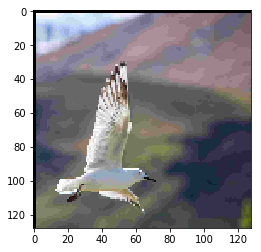

In [211]:
image = X_test[27]
true_label=y_test[27]
display_image(image, true_label)

Animals probability: 0.002782437513815239%
Birds probability: 0.003404847302590497%
Fishes probability: 8.14467870924318e-07%
Reptiles probability: 99.99381303787231%
Pridicted label: Reptile
True label: Reptiles


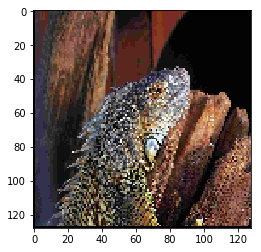

In [212]:
image = X_test[0]
true_label=y_test[0]
display_image(image, true_label)

Animals probability: 0.02590635558590293%
Birds probability: 0.10810345411300659%
Fishes probability: 0.00016505207440786762%
Reptiles probability: 99.86581802368164%
Pridicted label: Reptile
True label: Reptiles


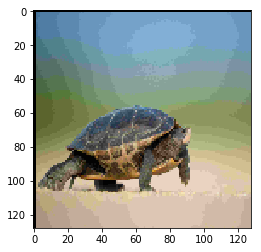

In [213]:
image = X_test[12]
true_label=y_test[12]
display_image(image, true_label)

In [209]:
y_test = np.array(y_test)
np.where(y_test=="Reptiles")

(array([  0,   1,   4,  12,  17,  30,  53,  57,  59,  62,  71, 102, 109,
        123, 126, 132, 136, 161, 164, 171, 186, 216, 217, 233, 241, 244,
        246, 254, 274, 283], dtype=int64),)